In [21]:
import os, glob, re, json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import List, Tuple
from PIL import Image, ImageOps
import pillow_heif
pillow_heif.register_heif_opener()   # habilita abertura de .heic/.heif no Pillow

In [26]:
def _pil_to_bgr(pil_img: "Image.Image") -> np.ndarray:
    """Converte PIL.Image para ndarray BGR uint8, aplicando orientação EXIF."""
    pil_img = ImageOps.exif_transpose(pil_img)
    if pil_img.mode not in ("RGB", "RGBA"):
        pil_img = pil_img.convert("RGB")
    arr = np.array(pil_img)  # RGB(A)
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[:, :, :3]  # descarta alpha; ajuste para BGRA se precisar
    return cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)


def carregar_imagem(path: str) -> np.ndarray | None:
    """
    Lê imagem em BGR (uint8). Suporta formatos do OpenCV e HEIC/HEIF via Pillow.
    """
    ext = os.path.splitext(path)[1].lower()
    if ext in (".heic", ".heif"):
        pil_img = Image.open(path)
        return _pil_to_bgr(pil_img)
    else:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"[aviso] não consegui abrir: {path}")
        return img


def _regex_tail_number(s: str) -> int:
    """
    Extrai um número "útil" do fim do nome para ordenação. 
    Se não encontrar, tenta qualquer número em s; se ainda não, retorna 0.
    """
    base = os.path.basename(s)
    m = re.search(r'(\d+)(?=\D*$)', base)  # último bloco numérico antes do fim
    if m: return int(m.group(1))
    m2 = re.search(r'(\d+)', base)
    return int(m2.group(1)) if m2 else 0

def ordenar_arquivos_imagem(caminho_pasta: str, recursivo: bool = False) -> List[str]:
    """
    Lista arquivos de imagem (case-insensitive), podendo vasculhar recursivamente.
    Retorna lista ordenada pelo número no final do nome e, depois, pelo nome.
    """
    exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp', '.heic', '.heif'}
    encontrados: List[str] = []

    if recursivo:
        for raiz, _, files in os.walk(caminho_pasta):
            for nome in files:
                if os.path.splitext(nome)[1].lower() in exts:
                    encontrados.append(os.path.join(raiz, nome))
    else:
        try:
            for nome in os.listdir(caminho_pasta):
                if os.path.splitext(nome)[1].lower() in exts:
                    encontrados.append(os.path.join(caminho_pasta, nome))
        except FileNotFoundError:
            print(f"[erro] pasta não encontrada: {os.path.abspath(caminho_pasta)}")
            return []

    # Remove duplicatas, ordena
    encontrados = list(set(encontrados))
    encontrados.sort(key=lambda f: (_regex_tail_number(f), os.path.basename(f).lower()))

    # Log curto para diagnóstico
    print(f"[debug] {len(encontrados)} imagem(ns) encontrada(s) em {os.path.abspath(caminho_pasta)}")
    if len(encontrados) < 2:
        # Mostra até 5 arquivos encontrados (se algum)
        for f in encontrados[:5]:
            print("  -", os.path.basename(f))
        if not encontrados:
            print("  (nenhuma imagem com extensões:", ", ".join(sorted(exts)), ")")
            print("  dicas: verifique maiúsculas (.HEIC), caminho e permissões.")
    return encontrados


def serializar_keypoints(kps: List[cv2.KeyPoint]) -> np.ndarray:
    """
    Converte lista de cv2.KeyPoint para array (N,7) -> (x,y,size,angle,response,octave,class_id)
    """
    if not kps:
        return np.zeros((0,7), dtype=np.float32)
    data = np.zeros((len(kps),7), dtype=np.float32)
    for i,k in enumerate(kps):
        data[i,0] = k.pt[0]
        data[i,1] = k.pt[1]
        data[i,2] = k.size
        data[i,3] = k.angle
        data[i,4] = k.response
        data[i,5] = k.octave
        data[i,6] = k.class_id
    return data


def criar_detector(nome: str):
    """
    Cria uma instância de um detector de características com parâmetros padronizados.
    """
    N_FEATURES_SIFT_ORB = 500 

    nome = nome.lower()

    if nome == 'sift':
        return cv2.SIFT_create(nfeatures=N_FEATURES_SIFT_ORB), cv2.NORM_L2, 'sift'

    if nome == 'orb':
        return cv2.ORB_create(nfeatures=N_FEATURES_SIFT_ORB), cv2.NORM_HAMMING, 'orb'

    if nome == 'akaze':
        return cv2.AKAZE_create(threshold=0.005), cv2.NORM_HAMMING, 'akaze'

    raise ValueError(f"Detector '{nome}' não reconhecido.")

In [27]:
def desenhar_keypoints_custom(imagem, keypoints, cor=(0, 255, 0), raio=3, espessura=2):
    """
    Desenha keypoints em uma imagem com círculos customizáveis.
    
    Args:
        imagem: A imagem (colorida, BGR) onde desenhar.
        keypoints: Lista de cv2.KeyPoint.
        cor: Tupla BGR para a cor dos círculos.
        raio: Raio de cada círculo.
        espessura: Espessura da borda do círculo (-1 para preenchido).
        
    Returns:
        Uma nova imagem com os keypoints desenhados.
    """
    # Cria uma cópia para não modificar a imagem original
    img_desenhada = imagem.copy()

    if keypoints is None:
        return img_desenhada

    for kp in keypoints:
        center = (int(kp.pt[0]), int(kp.pt[1]))
        cv2.circle(img_desenhada, center, raio, cor, espessura)

    return img_desenhada

In [28]:
# --------- ETAPA 2 PRINCIPAL (Focada apenas em Extração de Features) ---------
def analisar_conjunto(caminho_pasta: str, detectores: List[str]):
    """
    Etapa 2: 
    - Extrai features (keypoints e descritores) com detectores padronizados.
    - Salva os resultados em arquivos .npz para as próximas etapas do pipeline.
    - Gera imagens de visualização para os keypoints e um resumo comparativo em CSV.
    """
    print("=========================================================")
    print(f"Analisando o conjunto de imagens em: '{caminho_pasta}'")
    print("=========================================================")

    raiz_resultados = os.path.join(
        "resultados_etapa2", os.path.basename(os.path.normpath(caminho_pasta)))
    os.makedirs(raiz_resultados, exist_ok=True)

    arquivos_de_imagem = ordenar_arquivos_imagem(caminho_pasta)
    if len(arquivos_de_imagem) < 2:
        print("Erro: São necessárias pelo menos 2 imagens na pasta.")
        return

    ordem_json = os.path.join(raiz_resultados, "ordem_imagens.json")
    with open(ordem_json, "w", encoding="utf-8") as f:
        json.dump([os.path.abspath(p) for p in arquivos_de_imagem],
                  f, indent=2, ensure_ascii=False)
    print(f"-> Ordem das imagens salva em '{ordem_json}'")

    linhas_resumo = []

    for nome_detector in detectores:
        print(f"\n--- Análise para o detector: {nome_detector.upper()} ---")
        try:
            detector, norm_type, detector_slug = criar_detector(nome_detector)
        except ValueError as e:
            print(f"  [Erro] {e}")
            continue

        dir_detector = os.path.join(raiz_resultados, detector_slug)
        os.makedirs(dir_detector, exist_ok=True)

        total_keypoints = 0

        for i, caminho in enumerate(arquivos_de_imagem):
            img_bgr = carregar_imagem(caminho)
            if img_bgr is None:
                continue

            img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
            keypoints, descriptors = detector.detectAndCompute(img_gray, None)

            n_kp = len(keypoints) if keypoints is not None else 0
            total_keypoints += n_kp
            linhas_resumo.append(
                [detector_slug, os.path.basename(caminho), n_kp])

            # Salva as features (keypoints + descritores) para a próxima etapa do pipeline
            arr_kp = serializar_keypoints(keypoints or [])
            if descriptors is None:
                # Garante que descritores vazios tenham a forma correta
                desc_size = detector.descriptorSize() if hasattr(
                    detector, 'descriptorSize') else 0
                desc_type = np.uint8 if norm_type == cv2.NORM_HAMMING else np.float32
                descriptors = np.zeros((0, desc_size), dtype=desc_type)

            saida_npz = os.path.join(dir_detector, f"img_{i:03d}_features.npz")
            np.savez_compressed(saida_npz, keypoints=arr_kp,
                                descriptors=descriptors, imagem_absoluta=caminho)

            # Gera e salva a imagem de overlay com os keypoints
            img_kp = desenhar_keypoints_custom(
                img_bgr, keypoints, cor=(0, 255, 0), raio=8, espessura=8) 
            saida_overlay = os.path.join(
                dir_detector, f"img_{i:03d}_keypoints.jpg")
            cv2.imwrite(saida_overlay, img_kp)

            # Mostra o preview da primeira imagem no notebook para feedback visual
            if i == 0:
                print(
                    f"  -> {n_kp} keypoints encontrados na primeira imagem. Gerando preview...")
                plt.figure(figsize=(12, 8))
                plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
                plt.title(
                    f'Keypoints ({detector_slug.upper()}) em {os.path.basename(caminho)}')
                plt.axis('off')
                plt.show()

        media_kp = total_keypoints / \
            len(arquivos_de_imagem) if arquivos_de_imagem else 0
        print("\n--- Resumo Estatístico ---")
        print(
            f"Média de keypoints por imagem ({detector_slug}): {media_kp:.2f}")

    # Salva o arquivo CSV com o resumo final dos keypoints
    import csv
    csv_path = os.path.join(raiz_resultados, "resumo_keypoints.csv")
    with open(csv_path, "w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["detector", "imagem", "num_keypoints"])
        w.writerows(linhas_resumo)
    print(f"\n-> Resumo de keypoints salvo em '{csv_path}'")

Analisando o conjunto de imagens em: 'imagens-t2'
[debug] 86 imagem(ns) encontrada(s) em /home/jasmine/Documents/AAJasmine/ComputerVision/imagens-t2
-> Ordem das imagens salva em 'resultados_etapa2/imagens-t2/ordem_imagens.json'

--- Análise para o detector: SIFT ---
  -> 500 keypoints encontrados na primeira imagem. Gerando preview...


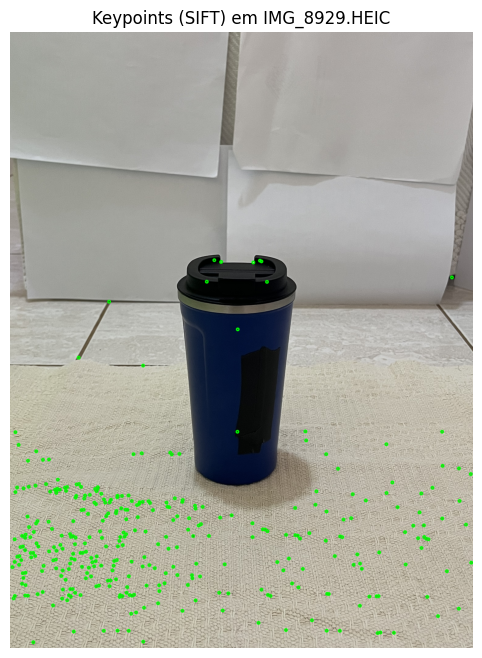


--- Resumo Estatístico ---
Média de keypoints por imagem (sift): 500.35

--- Análise para o detector: ORB ---
  -> 500 keypoints encontrados na primeira imagem. Gerando preview...


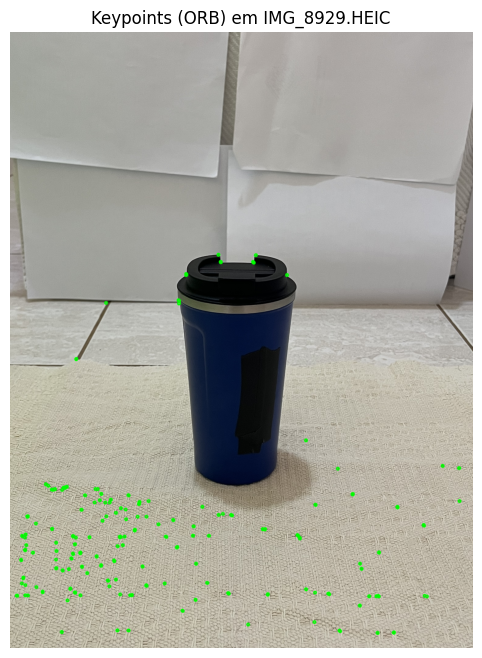


--- Resumo Estatístico ---
Média de keypoints por imagem (orb): 500.00

--- Análise para o detector: AKAZE ---
  -> 1056 keypoints encontrados na primeira imagem. Gerando preview...


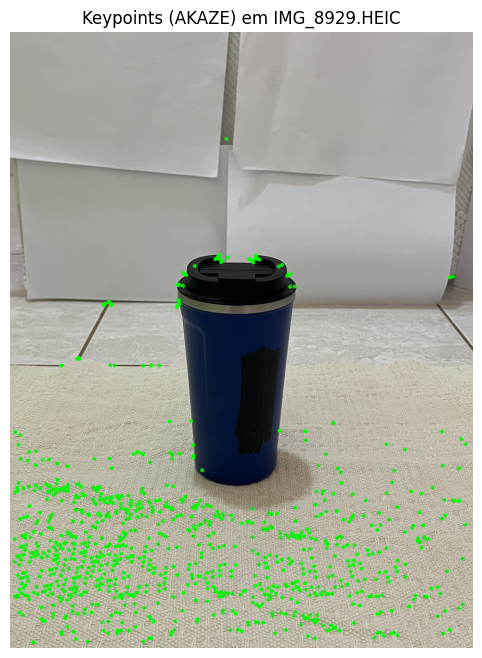


--- Resumo Estatístico ---
Média de keypoints por imagem (akaze): 950.98

-> Resumo de keypoints salvo em 'resultados_etapa2/imagens-t2/resumo_keypoints.csv'


In [29]:
caminho_normal = "imagens-t2"
detectores = ['sift', 'orb', 'akaze']
analisar_conjunto(caminho_normal, detectores)